# Exercise 1: Discrete distributions

## 1.

We first sample $U$ with an uniform distribution on $[0,1]$. Then, there exists an only $k\in\{1,...,n\}$ such that
$$
\sum_{j=1}^{k-1} \pi_j \le U < \sum_{j=1}^k \pi_j
$$
Finally we set $Y=v_{k}$.

This is a special case of inverse transform sampling.

## 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
def sample_discrete_distrib(N, V, PI):
  '''Sample N times from a discrete distribution with values V and probabilities PI.'''

  # First assert that V and PI have same length and that PI sums to 1
  K = len(V)
  assert len(V) == len(PI)
  PI_cumsum = np.cumsum(PI)
  assert np.isclose(PI_cumsum[-1], 1)

  # Sample from uniform distribution
  U = np.random.uniform(0, 1, N)

  Y = np.full(N, V[0])
  for k in range(1, K):
    Y[(PI_cumsum[k-1] <= U) & (U < PI_cumsum[k])] = V[k]

  return Y

## 3.

In [3]:
N = 10000
V = np.array([0., 1., 0.5, 2.])
PI = np.array([0.1, 0.2, 0.4, 0.3])

Y = sample_discrete_distrib(N, V, PI)

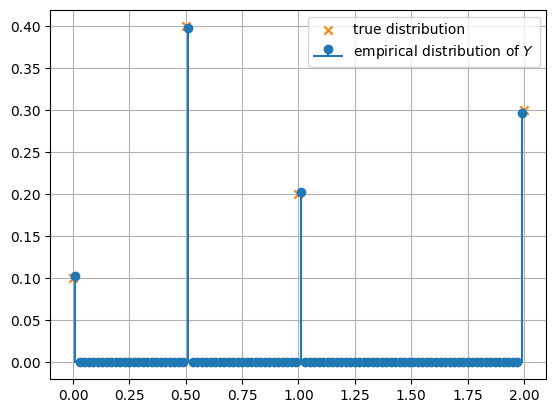

In [4]:
hist, bin_edges = np.histogram(Y, bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.stem(bin_centers, hist / N, basefmt='', label='empirical distribution of $Y$')
plt.scatter(V, PI, marker='x', c='C1', label='true distribution')
plt.legend()
plt.grid()
plt.show()

The empirical distribution of $Y$ matches the theoretical one.

# Exercise 2: Gaussian mixture model and the EM algorithm

## 1.

The parameters of the model are $\theta=((\alpha_i)_{1\le i\le m}, (\mu_i)_{1\le i\le m}, (\Sigma_i)_{1\le i\le m})$.

We can decompose the likelihood using the law of total probability:
$$
\mathcal L(x;\theta)= \prod_{i=1}^n f_\theta (x_i)=\prod_{i=1}^n \sum_{j=1}^m f_\theta(x_i|Z_i=j) \,\mathbb P_\theta(Z_i=j)
$$
For all i and j,
$$f_\theta(x_i|Z_i=j)=\mathcal N(x_i\,|\,\mu_j,\Sigma_j)=\frac{1}{(2\pi)^{d/2}|\Sigma_j|^{1/2}}\exp\Big(-\frac{1}{2}(x_i-\mu_j)^\top \Sigma_j^{-1} (x_i-\mu_j)\Big)$$
and
$$\mathbb P_\theta(Z_i=j)=\alpha_j$$
So the log-likelihood of $\theta$ given $x$ is
$$\log \mathcal L(x;\theta)=\sum_{i=1}^n\log\Big(\sum_{j=1}^m \alpha_j \,\mathcal N(x_i\,|\,\mu_j,\Sigma_j)\Big)$$

## 2.

In [5]:
def sample_GMM(N, alphas, mus, sigmas):
  '''Sample N times from a mixture of Gaussians with parameters alphas, mus, sigmas'''

  # First assert that alpha, mu, sigma have same length and that alpha sums to 1
  m = len(alphas)
  assert len(mus) == m
  assert len(sigmas) == m
  assert np.isclose(np.sum(alphas), 1)
  # Also assert that mu and sigma are dimensionally consistent
  m, dim = mus.shape
  assert sigmas.shape == (m, dim, dim)

  # First Sample the Z_i s using exercise 1
  Z = sample_discrete_distrib(N, np.arange(m), alphas)

  # Then sample each X_i
  X = np.zeros((N, dim))
  for i in range(N):
    X[i] = np.random.multivariate_normal(mean=mus[Z[i]], cov=sigmas[Z[i]])

  return X

Let us visualize our algorithm on a simple example with 2 Gaussians.

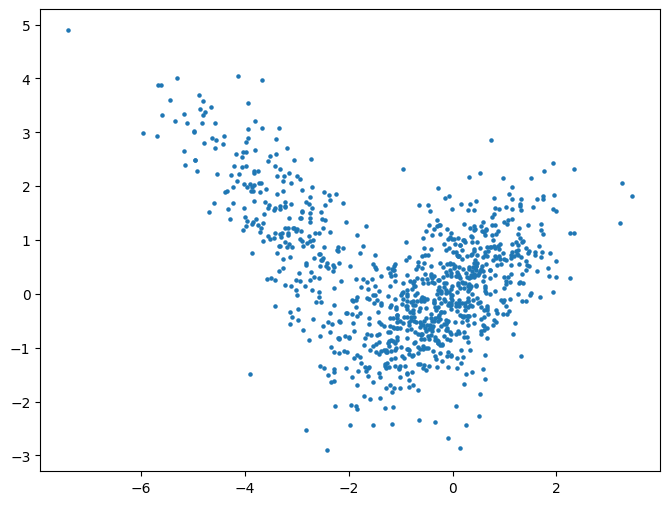

In [6]:
N = 1000
true_alphas = np.array([0.7, 0.3])
true_mus = np.array([[0., 0.],
                [-3., 1.]])
true_sigmas = np.array([
    [[1., 0.5], [0.5, 0.8]],
     [[1.5, -1.5], [-1.5, 2.]]
])

X = sample_GMM(N, true_alphas, true_mus, true_sigmas)

plt.subplots(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], s=5)
plt.show()

## 3.

### E-step

We have to compute $$Q(\theta\,|\,\theta_t)= \mathbb E_{z\,|\,x,\theta_t}[\log p(x,z,\theta)]$$
$z$ takes values in a finite set, so we have
$$\mathbb E_{z\,|\,x,\theta_t}[\log p(x_i,z,\theta)] = \sum_{j=1}^m \mathbb P(z=j\,|\,x_i,\theta_t) \,\log p(x_i,z=j,\theta)$$
Define
$$\gamma_{i,j}=\mathbb P(z=j\,|\,x_i,\theta_t)$$
Using Bayes' theorem, we have
$$\gamma_{i,j} = \frac{p(x_i\,|\,z=j,\theta_t) \;\mathbb P (z=j\,|\,\theta_t)}{\sum_{k=1}^m p(x_i\,|\,z=j,\theta_t) \;\mathbb P (z=j\,|\,\theta_t)}=\frac{\alpha_{t,j} \;\mathcal N(x_i\,|\,\mu_{t,j},\Sigma_{t,j})}{\sum_{k=1}^m \alpha_{t,k} \;\mathcal N(x_i\,|\,\mu_{t,k},\Sigma_{t,k})}$$
And,
$$
p(x_i,z=j,\theta) = p(x_i\,|\,z=j,\theta) \;\mathbb P (z=j\,|\,\theta) = \alpha_{j} \;\mathcal N(x_i\,|\,\mu_{j},\Sigma_{j})
$$
So finally,
$$
\boxed{
Q(\theta\,|\,\theta_t)=\sum_{i=1}^n \sum_{j=1}^m \gamma_{i,j} \Big(\log \alpha_{j} +\log\mathcal N(x_i\,|\,\mu_{j},\Sigma_{j})\Big)_.
}
$$

### M-step

* **Maximization of $\alpha$**

We have the following optimization problem:
$$\text{maximize }\sum_{i=1}^n\sum_{j=1}^m \gamma_{i,j}\log\alpha_j$$
$$\text{subject to}\quad \alpha\ge 0, \quad\sum_{j=1}^m \alpha_j=1$$
We can show that the optimal $\alpha$ is
$$\alpha_{t+1}=\Big(\frac{1}{n}\sum_{i=1}^n \gamma_{i,j}\Big)_{1\le j\le m}$$

* **Maximization of $\mu$**

Diffentiating $Q$ with respect to $\mu_j$ we have
$$
\frac{\partial}{\partial \mu_j} Q
=\sum_{i=1}^n\gamma_{i,j}\frac{\frac{\partial}{\partial \mu_j} \,\mathcal N(x_i\,|\,\mu_j,\Sigma_j)}{\mathcal N(x_i\,|\,\mu_j,\Sigma_j)}
=\sum_{i=1}^n \gamma_{i,j}\,\Sigma_j^{-1}\,(x_i-\mu_j)
$$
This is an unconstrained problem so we need to set the differential to 0. Because $\Sigma_j$ is always invertible, we have
$$
\frac{\partial}{\partial \mu_j} Q=0\iff \sum_{i=1}^n \gamma_{i,j}(x_i-\mu_j)=0
$$
and finally
$$
\mu_{t+1,j}=\frac{\sum_i \gamma_{i,j}\,x_i}{\sum_i \gamma_{i,j}}
$$

* **Maximization of $\Sigma$**

After computations, we have

$$
\Sigma_{t+1,j}=\frac{\sum_i \gamma_{i,j}\,(x_i-\mu_{t+1,j})\,(x_i-\mu_{t+1,j})^\top}{\sum_i \gamma_{i,j}}
$$

### Implementation

In practice, we notice that $\mathcal N(x_i|\mu_{t,j},\Sigma_{t,j})$ can get very small, leading to numerical instability. Therefore, we implement the E-step by first computing
$$\tau_{i,j}=\log (\alpha_{t,j}\, \mathcal N(x_i\,|\,\mu_{t,j},\Sigma_{t,j}))= \log \alpha_{t,j}-\frac d 2 \log(2\pi) - \frac 1 2 \log(|\Sigma_{t,j}|)-\frac 1 2 (x_i-\mu_{t,j})^\top \Sigma_{t,j}^{-1}(x_i-\mu_{t,j})$$
and then noticing that
$$\gamma_{i,j}=\frac{\exp(\tau_{i,j})}{\sum_{k=1}^m \exp(\tau_{i,k})}$$
We then implement the M-step using the closed-form expressions for $\alpha_{t+1}$, $\mu_{t+1}$ and $\Sigma_{t+1}$ described previously.

In [7]:
def EM_step(X, current_alpha, current_mus, current_sigmas):
  '''Perform one EM_step using the closed-form expressions we just defined'''
  N, dim = X.shape
  m = len(current_alpha)

  # E-STEP: COMPUTE THE GAMMAS
  tau = np.log(current_alpha[None, :]) \
    - dim / 2 * np.log(2*np.pi) \
    - 1 / 2 * np.linalg.slogdet(current_sigmas)[1][None, :] \
    - 1 / 2 * np.squeeze((X[:, None, None, :] - current_mus[None, :, None, :]) @ np.linalg.inv(current_sigmas)[None, :, :, :] @ (X[:, None, :, None] - current_mus[None, :, :, None]))
  log_gammas = tau - scipy.special.logsumexp(tau, axis=1)[:, None] # Using logsumexp to avoid numerical instability
  gammas = np.exp(log_gammas)

  # M-STEP
  alpha = np.sum(gammas, axis=0) / N
  mus = np.sum(gammas[:, :, None] * X[:, None, :], axis=0) / np.sum(gammas, axis=0)[:, None]
  sigmas = np.sum(gammas[:, :, None, None] * (X[:, None, :] - mus[None, :, :])[:, :, :, None] * (X[:, None, :] - mus[None, :, :])[:, :, None, :], axis=0) \
    / np.sum(gammas, axis=0)[:, None, None]
  sigmas += np.eye(dim)[None, :, :] * 1e-6 # To avoid singular matrices

  return alpha, mus, sigmas

We also define a log likelihhod function, that will be used to evaluate the log likelihood of $\theta_t$ at each step.

In [8]:
def log_likelihood(X, alphas, mus, sigmas):
  '''Compute the log-likelihhod of observations X under parameters alphas, mus, sigmas'''
  N, dim = X.shape
  m = len(alphas)

  tau = np.log(alphas[None, :]) \
    - dim / 2 * np.log(2*np.pi) \
    - 1 / 2 * np.linalg.slogdet(sigmas)[1][None, :] \
    - 1 / 2 * np.squeeze((X[:, None, None, :] - mus[None, :, None, :]) @ np.linalg.inv(sigmas)[None, :, :, :] @ (X[:, None, :, None] - mus[None, :, :, None]))
  ll = np.sum(scipy.special.logsumexp(tau, axis=1))
  return ll

We can then define the EM algorithm, looping over the function `EM_step`

In [9]:
def EM_algorithm(X, m):
  '''Run the EM algorithm on dataset X for a mixture model of m gaussians.
  Return the final alphas, mus, sigmas, and the list of the log likelihoods at
  each step.'''
  N, dim = X.shape

  # INITIALIZATION
  # We initialize alpha as the uniform distribution on [1,m], sigmas as identity matrices
  # and mus as random as the mean of the data + a normal distribution
  alpha = np.ones(m) / m
  sigmas = np.array([np.eye(dim) for _ in range(m)])
  mus = np.mean(X, axis=0)[None, :] + np.random.normal(size=(m, dim)) * np.std(X, axis=0)[None, :]

  log_likelihoods = []

  MAX_STEPS = 200
  # MAIN LOOP
  for _ in range(MAX_STEPS):
    new_alpha, new_mus, new_sigmas = EM_step(X, alpha, mus, sigmas)

    # Test if the new theta is close to the old one. In that case, stop the algorithm
    if np.allclose(new_alpha, alpha) and np.allclose(new_mus, mus) and np.allclose(new_sigmas, sigmas):
      return alpha, mus, sigmas, log_likelihoods

    alpha, mus, sigmas = new_alpha, new_mus, new_sigmas
    log_likelihoods.append(log_likelihood(X, alpha, mus, sigmas))

  return alpha, mus, sigmas, log_likelihoods

In [10]:
alpha, mus, sigmas, log_likelihoods = EM_algorithm(X, m=2)

We plot the log-likelihood over the iterations of the algorithm.

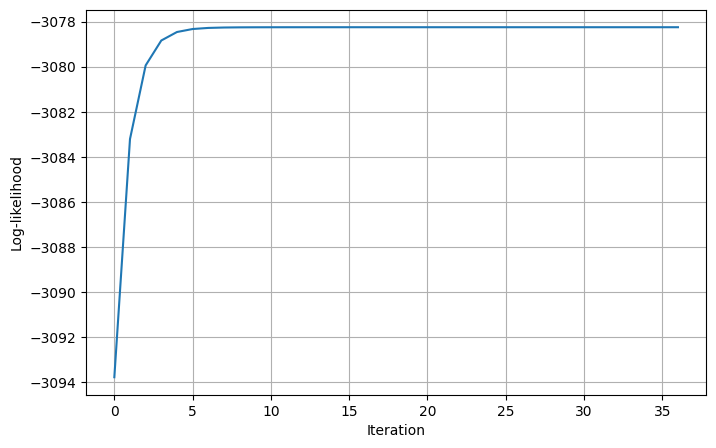

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(log_likelihoods)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-likelihood')
ax.grid()
plt.show()

## 4.

To see if the estimated parameters are far from the original ones, we will plot the ellipsoids corresponding to both the true $\mu_j$ and $\Sigma_j$, and the ones returned by our algorithm.

Let us first define the function allowing to plot ellipsoids, given $\mu$ and $\Sigma$.

In [12]:
from matplotlib.patches import Ellipse

In [13]:
def plot_ellipse(ax, mu, sigma, label=None, **kwargs):

  assert mu.shape == (2,)
  assert sigma.shape == (2,2)

  eigvals, eigvecs = np.linalg.eigh(sigma)
  order = eigvals.argsort()[::-1]
  eigvals = eigvals[order]
  eigvecs = eigvecs[:, order]

  width, height = 2.0 * np.sqrt(eigvals)

  # Angle of rotation in degrees: angle of first eigenvector
  vx, vy = eigvecs[:, 0]
  angle = np.degrees(np.arctan2(vy, vx))

  ax.add_patch(Ellipse(xy=mu, width=width*0.5, height=height*0.5, angle=angle, fill=False, **kwargs))
  ax.add_patch(Ellipse(xy=mu, width=width, height=height, angle=angle, fill=False, **kwargs))
  ax.add_patch(Ellipse(xy=mu, width=width*1.5, height=height*1.5, angle=angle, fill=False, **kwargs))
  ax.add_patch(Ellipse(xy=mu, width=width*2, height=height*2, angle=angle, fill=False, **kwargs))

  ax.scatter(mu[0], mu[1], marker='x', s=100, label=label, **kwargs)

True parameters: alpha=[0.7 0.3], 
mus=[[ 0.  0.]
 [-3.  1.]], 
sigmas=[[[ 1.   0.5]
  [ 0.5  0.8]]

 [[ 1.5 -1.5]
  [-1.5  2. ]]]
Estimated parameters: alpha=[0.3022583 0.6977417], 
mus=[[-3.01618831  1.08962722]
 [-0.09233909 -0.02285674]], 
sigmas=[[[ 1.42525251 -1.37491724]
  [-1.37491724  1.9061233 ]]

 [[ 0.98811438  0.55297009]
  [ 0.55297009  0.86485007]]]


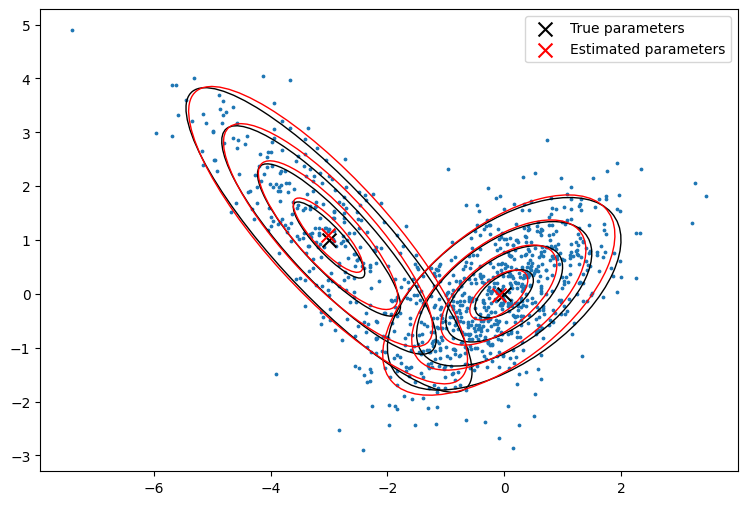

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(X[:,0], X[:,1], s=3,)

plot_ellipse(ax, true_mus[0], true_sigmas[0], color='black', label="True parameters")
plot_ellipse(ax, true_mus[1], true_sigmas[1], color='black')

plot_ellipse(ax, mus[0], sigmas[0], color='red', label='Estimated parameters')
plot_ellipse(ax, mus[1], sigmas[1], color='red')

plt.legend()

print(f'True parameters: alpha={true_alphas}, \nmus={true_mus}, \nsigmas={true_sigmas}')
print(f'Estimated parameters: alpha={alpha}, \nmus={mus}, \nsigmas={sigmas}')

plt.show()

Thus, we observe that **the estimated parameters are close to the original ones**.

## 5.

In [15]:
import pandas as pd

In [16]:
df = pd.read_csv("/content/WPP2024_Demographic_Indicators_Medium.csv")

# Keep only columns CBR and CDR
df = df[["CBR", "CDR"]]

# Drop datapoints containing NaN
df = df.dropna()

print(len(df))

/tmp/ipython-input-3379582673.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/WPP2024_Demographic_Indicators_Medium.csv")


83805


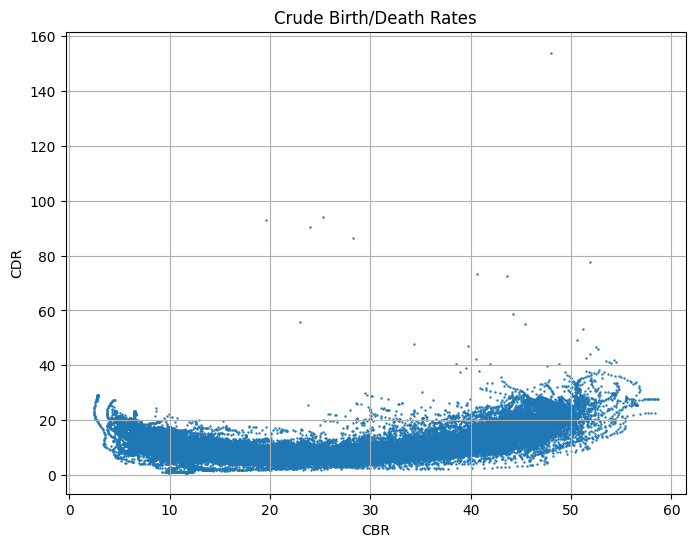

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(df['CBR'], df['CDR'], s=2, marker='.')
ax.grid()
ax.set_title("Crude Birth/Death Rates")
ax.set_xlabel('CBR')
ax.set_ylabel('CDR')
plt.show()

Each of the 83805 data point represent a country and a year between 1950 and 2100. The distribution of the data could indicate the use of a Gaussian mixture model, with

## 6.

We run the EM algorithm for $m=3$.

In [18]:
X = df.to_numpy()
assert X.shape == (83805, 2)

m = 3

alpha, mus, sigmas, log_likelihoods = EM_algorithm(X, m=m)

We plot the log likelihood to confirm that the algorithm converged.

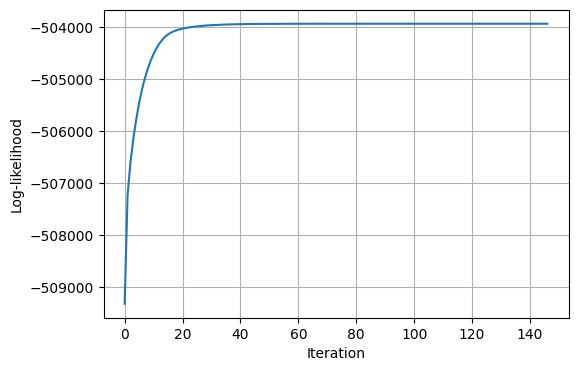

In [19]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(log_likelihoods)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-likelihood')
ax.grid()
plt.show()

And we plot the estimated clusters.

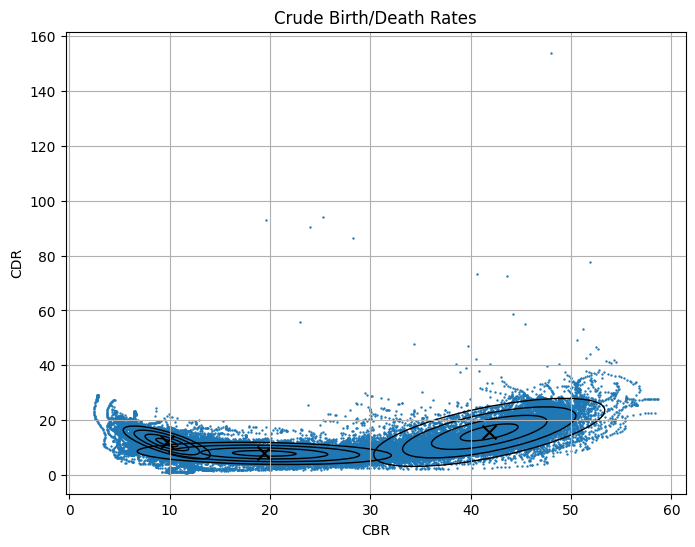

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid()

ax.scatter(df['CBR'], df['CDR'], s=2, marker='.')

for j in range(m):
  plot_ellipse(ax, mus[j], sigmas[j], color='black')

ax.set_title("Crude Birth/Death Rates")
ax.set_xlabel('CBR')
ax.set_ylabel('CDR')
plt.show()

Going from right to left the three clusters are:

1.   **High Death Rate - High Birth Rate**, with the birth rate positively correlated to the death rate. This corresponds to developing countries in the early stages of their demographic transition. As the demographic transition advances, both the birth rate and the death rate decrease.

2.  **Low Death Rate - Medium Birth Rate**, with uncorrelated birth and death rates. This corresponds to developed countries in the later stages of their demographic transition, where the death rate is low.

3. **High Death Rate - Low Birth Rate**, with the birth rate negatively correlated to the death rate. This could correspond to aging countries, where the low birth rate has led to an aging population, which could increase the death rate. Alternatively, this might corresponds to countries in crisis, e.g due to war or to epidemic. The more this crisis is intense, the higher the death rate is, and the lower the birth rate is.



## 7.

Let's first implement the BIC criterion. The degrees of freedom of the mixture model with $m$ clusters are:
* $m-1$ degrees of freedom for $\alpha$
* $d$ degrees of freedom for $\mu_j$ for all $j=1,...,m$, and
* $d(d+1)/2$ degrees of freedom for each $\Sigma_j$ (space of symmetric matrices).
Therefore, in total we have
$$\operatorname{df}(m)=m\,(d^2/2+3d/2+1)-1$$

In [21]:
def BIC(X, alpha, mus, sigmas):
  N, dim = X.shape
  m = len(alpha)

  ll = log_likelihood(X, alpha, mus, sigmas)
  df = m * (dim**2/2 + 3*dim/2 + 1) - 1

  return - ll + df * np.log(N) / 2

In [22]:
def pdf(X, alpha, mus, sigmas):
  N, dim = X.shape
  m = len(alpha)

  tau = np.log(alpha[None, :]) \
    - dim / 2 * np.log(2*np.pi) \
    - 1 / 2 * np.linalg.slogdet(sigmas)[1][None, :] \
    - 1 / 2 * np.squeeze((X[:, None, None, :] - mus[None, :, None, :]) @ np.linalg.inv(sigmas)[None, :, :, :] @ (X[:, None, :, None] - mus[None, :, :, None]))

  return np.sum(np.exp(tau), axis=1)

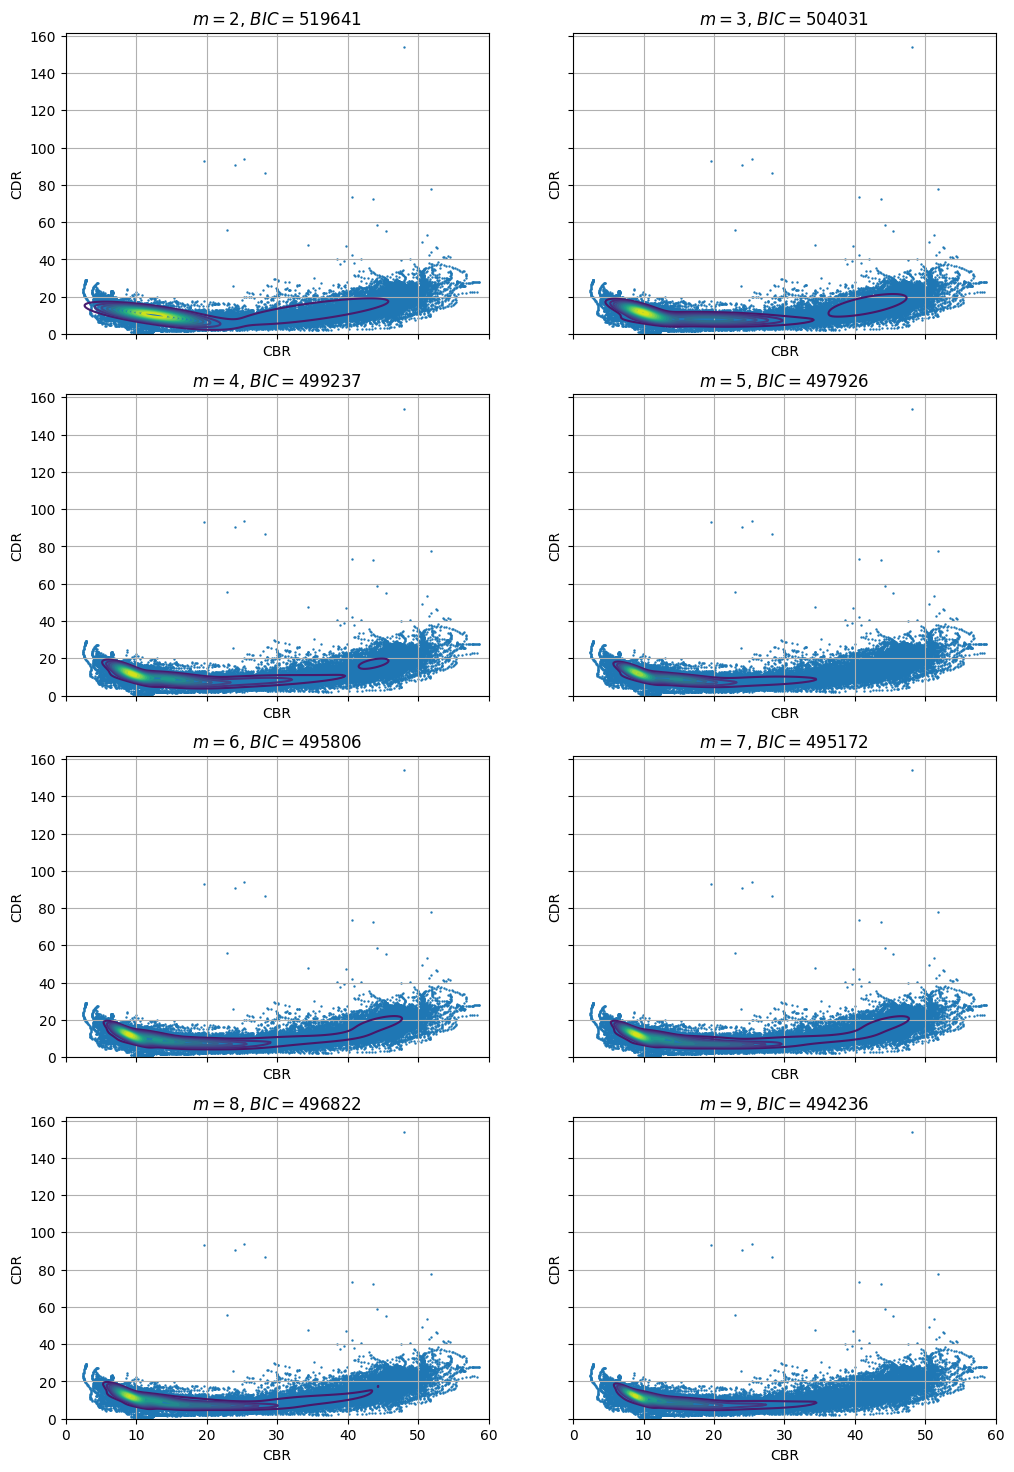

In [23]:
fig, axs = plt.subplots(4, 2, figsize=(12,18), sharex=True, sharey=True)

for i, j, m in [(0, 0, 2), (0, 1, 3), (1, 0, 4), (1, 1, 5), (2, 0, 6), (2, 1, 7), (3, 0, 8), (3, 1, 9)]:

  alpha, mus, sigmas, _ = EM_algorithm(X, m=m)

  axs[i, j].scatter(X[:,0], X[:,1], s=2, marker='.')

  x, y = np.linspace(0, 60, 200), np.linspace(0, 100, 200)
  mesh_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
  axs[i, j].contour(x, y, pdf(np.array(mesh_grid), alpha, mus, sigmas).reshape(200,200).T, levels=16)

  bic = BIC(X, alpha, mus, sigmas)

  axs[i, j].set_title(f"$m={m}$, $BIC={bic:.0f}$")
  axs[i, j].set_xlabel('CBR')
  axs[i, j].set_ylabel('CDR')
  axs[i, j].grid()
plt.show()

# Exercise 3: Importance sampling

## 1.

We define the functions:

*   $f(x) = 2 \sin(\frac{\pi}{1.5} x) \cdot \mathbf{1}_{\mathbb{R}^+}(x)$
*   $p(x) = x^{0.65} \cdot e^{-x^2/2} \cdot \mathbf{1}_{\mathbb{R}^+}(x)$ (unnormalized, similar to a $\chi$ distribution)
*   $q(x) = \frac{2}{\sqrt{2\pi(1.5)}} e^{-\frac{(x-0.8)^2}{2(1.5)}}$ (scaled normal distribution $N(0.8, 1.5)$)

In [24]:
f = lambda x: 2 * np.sin(np.pi/1.5 * x) * (x>=0)
p = lambda x: np.maximum(0,x)**.65 * np.exp(-x**2/2)
q = lambda x: 2 / np.sqrt(2*np.pi*1.5) * np.exp(-(x-0.8)**2/2/1.5)

To implement importance sampling, we follow these steps:

1.  Sample from the proposal distribution $q(x)$: Generate $N$ samples $X_i$ from $N(0.8, 1.5)$.
2.  Calculate importance weights: For each sample $X_i$, compute the weight $w_i = \frac{p(X_i)}{q(X_i)}$. Samples where $X_i < 0$ will result in $p(X_i)=0$, effectively discarding them as $p$ is supported only on $\mathbb{R}^+$.
3.  Normalize importance weights: Calculate normalized weights $\tilde{w}_i = \frac{w_i}{\sum_{j=1}^N w_j} N$.
4.  Estimate the expectation: The expectation $E_p[f(x)]$ is approximated by $\frac{1}{N} \sum_{i=1}^N \tilde{w}_i f(X_i)$.

In [25]:
def run_importance_sampling(N_samples, mu_q=0.8, sigma_q_sq=1.5):
  """Performs importance sampling to estimate E[f(X)] where X ~ p."""
  # Redefine q based on the input mu_q and sigma_q_sq
  q_local = lambda x: 2 / np.sqrt(2*np.pi*sigma_q_sq) * np.exp(-(x-mu_q)**2/2/sigma_q_sq)

  # Sample from the proposal distribution q
  X = np.random.normal(loc=mu_q, scale=np.sqrt(sigma_q_sq), size=N_samples)

  # Calculate importance weights and normalized importance wieghts
  importance_weights = p(X) / q_local(X)
  normalized_importance_weights = importance_weights / np.sum(importance_weights) * N_samples

  # Estimate the expectation
  estimate = 1/N_samples * np.sum(normalized_importance_weights * f(X))
  return estimate

# Run the importance sampling with N=1,000,000 samples
N = 1000000
estimated_expectation = run_importance_sampling(N)
print(f"Estimated expectation of f(x) using importance sampling: {estimated_expectation}")

Estimated expectation of f(x) using importance sampling: 0.7710435721533684


The output shows the estimated expectation of $f(x)$ when $x$ is distributed according to $p(x)$, using importance sampling with $N=1,000,000$ samples from the specified $q(x)$ distribution. The value should be around $0.77$ as observed in the previous run.

## 2.

In [26]:
sample_sizes = [1e1, 1e2, 1e3, 1e4]

N_ESTIMATES = 1000 # Number of estimations we run for each N, in order to compute a variance

means = []
vars = []

for N in sample_sizes:
  estimates = np.zeros(N_ESTIMATES)
  for i in range(N_ESTIMATES):
    estimates[i] = run_importance_sampling(int(N))
  means.append(np.mean(estimates))
  vars.append(np.var(estimates))

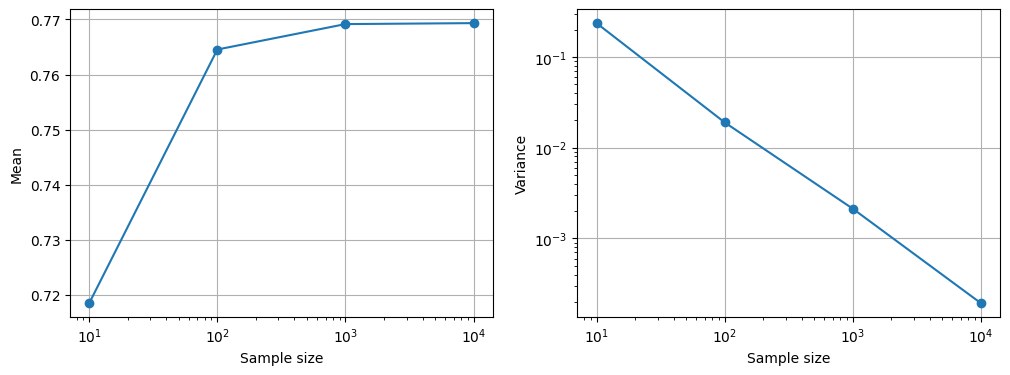

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True)

axs[0].plot(sample_sizes, means, 'o-')
axs[0].set_xscale('log')
axs[0].grid()
axs[0].set_xlabel('Sample size')
axs[0].set_ylabel('Mean')

axs[1].plot(sample_sizes, vars, 'o-')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid()
axs[1].set_xlabel('Sample size')
axs[1].set_ylabel('Variance')
plt.show()

As the sample size increases, the mean of the importance sampling estimate converges towards the true value, which is around $0.77$. The variances decreases in $O(1/n)$, as expected for a Monte-Carlo simulation.

## 3.

We now run the same simulations for $N=10, 100, ...$ with an ill-defined $\mu=6$.

In [28]:
means_mu_6 = []
vars_mu_6 = []

for N in sample_sizes:
  estimates = np.zeros(N_ESTIMATES)
  for i in range(N_ESTIMATES):
    estimates[i] = run_importance_sampling(int(N), mu_q=6)
  means_mu_6.append(np.mean(estimates))
  vars_mu_6.append(np.var(estimates))

We now plot the new estimates' mean and variance on the same plot.

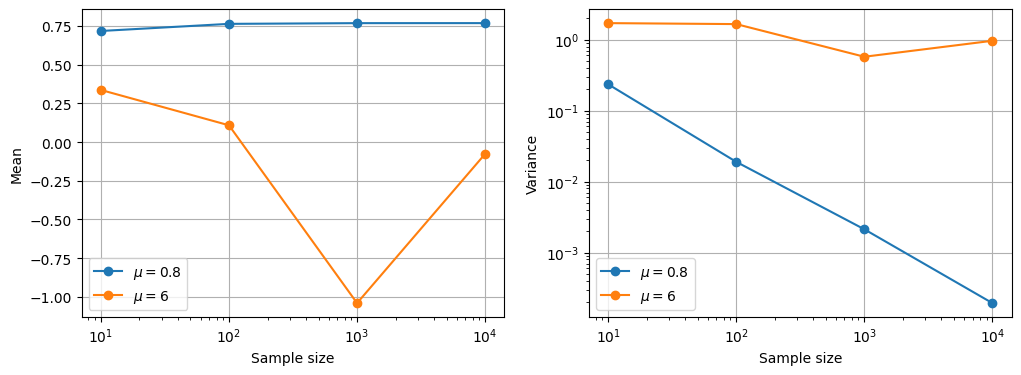

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12,4), sharex=True)

axs[0].plot(sample_sizes, means, 'o-', label='$\\mu=0.8$')
axs[0].plot(sample_sizes, means_mu_6, 'o-', label='$\\mu=6$')
axs[0].set_xscale('log')
axs[0].grid()
axs[0].set_xlabel('Sample size')
axs[0].set_ylabel('Mean')
axs[0].legend()

axs[1].plot(sample_sizes, vars, 'o-', label='$\\mu=0.8$')
axs[1].plot(sample_sizes, vars_mu_6, 'o-', label='$\\mu=6$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].grid()
axs[1].set_xlabel('Sample size')
axs[1].set_ylabel('Variance')
axs[1].legend()

plt.show()

For $\mu=6$, the mean of importance sampling estimate no longer seems to converge to the true value. Moreover, the standard deviation does not decrease as a function of the sample size and stays high.

Let us now compare the distributions of the importance weights for both values of $\mu$, for one estimate, with a sample size of 10000.

In [30]:
N_samples = 10000

# mu=0.8
X = np.random.normal(loc=0.8, scale=np.sqrt(1.5), size=N_samples)
importance_weights = p(X) / q(X)
normalized_importance_weights = importance_weights / np.sum(importance_weights) * N_samples

# mu=6
q_mu_6 = lambda x: 2 / np.sqrt(2*np.pi*1.5) * np.exp(-(x-6)**2/2/1.5)
X = np.random.normal(loc=6, scale=np.sqrt(1.5), size=N_samples)
importance_weights_mu_6 = p(X) / q_mu_6(X)
normalized_importance_weights_mu_6 = importance_weights_mu_6 / np.sum(importance_weights_mu_6) * N_samples

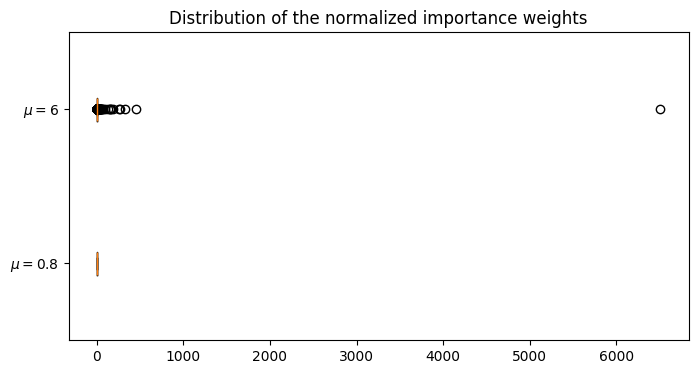

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
ax.boxplot([normalized_importance_weights, normalized_importance_weights_mu_6], tick_labels=['$\\mu=0.8$', '$\\mu=6$'], orientation='horizontal')
ax.set_title('Distribution of the normalized importance weights')
plt.show()

For $\mu=6$, the distribution of the importance weights is heavily skewed and have much more outliers.

To conclude, naive importance sampling is strongly dependent on the law $q$
according to which the data are generated: it must not be too different from the target distribution $p$.